# Sibyl evaluation results
Results of the evaluation by Sibyl team. Data available here: https://github.com/sibyl-team/ViraTrace-example

In [1]:
import sys
sys.path.append("InfectionModel/contagion_sim/")

In [2]:
import numpy as np
import pandas as pd
import tqdm

from multisim_model_evaluation import MultisimModelEvaluation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
contacts = pd.read_csv("contacts_t_12.csv.gz",index_col=0)

/opt/anaconda3/envs/bigdatalab_201911/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
observations = pd.read_csv("observ_t_12.csv.gz",index_col=0)

### Description

We have 12 days of contacts and a variable number of observations up until day 11

We want to obtain the risk prediction for the nodes on day 12

In [6]:
observations

,i,state,t
0,3032,1,7
1,6865,0,7
2,2868,0,7
3,518,0,7
4,7375,0,7
...,...,...,...
47,2207,0,11
48,5215,0,11
49,6637,0,11
50,5255,0,11


In [7]:
contacts

,i,j,t
0,0,3,0
1,0,2,0
2,0,1,0
3,0,1540,0
4,0,7583,0
...,...,...,...
1320789,9999,2726,12
1320790,9999,7050,12
1320791,9999,6990,12
1320792,9999,9242,12


In [8]:
contacts.rename(columns={'i': 'a', 'j': 'b'}, inplace=True)

In [9]:
observations.rename(columns={'i': 'a'}, inplace=True)

In [10]:
N = max(contacts['a'])+1
n_days = max(contacts['t'])
INFECTION_P = 0.02
INFECTED_P = 1/N
RECOVERY_T = 50

N_SIMS = 1000

SEED=4

edge_batch_gen = ((t, contacts[contacts.t == t]) for t in range(0, contacts.t.max()))

In [11]:
np.random.seed(SEED)
model = MultisimModelEvaluation(N, n_days, N_SIMS, edge_batch_gen, observations,
                                INFECTION_P, INFECTED_P, RECOVERY_T, None, recovery_dist='geometric',
                                directed_edges=True, tqdm=tqdm.tqdm)

In [12]:
model.run_sim()

Starting simulation...: 100%|██████████| 12/12 [00:37<00:00,  3.11s/it]


In [13]:
risk = pd.Series(model.I.sum(axis=1)).sort_values(ascending=False)
risk = (risk / risk.max())
risk.head(20)

8182    1.000
9438    1.000
5647    0.985
1       0.983
1085    0.983
8345    0.959
1839    0.953
6118    0.938
4698    0.938
6688    0.930
3032    0.928
5210    0.109
1016    0.106
2       0.090
5232    0.087
3       0.085
6693    0.080
6690    0.078
3033    0.077
6689    0.076
dtype: float64

In [14]:
def get_risk(model):
    risk = pd.Series(model.I.sum(axis=1)).sort_values(ascending=False)
    risk = (risk / risk.max())
    return risk

In [14]:
risk.to_csv("nodes_risk_original_model.csv")

/opt/anaconda3/envs/bigdatalab_201911/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Faster version

In [15]:
from sibyl_model_eval import FasterEvaluationModel

In [16]:
np.random.seed(SEED)
edge_batch_gen = ((t, contacts[contacts.t == t]) for t in range(0, contacts.t.max()))

our_model = FasterEvaluationModel(N, n_days, N_SIMS, edge_batch_gen, observations,
                                INFECTION_P, INFECTED_P, RECOVERY_T, None, recovery_dist='geometric',
                                directed_edges=True, tqdm=tqdm.tqdm)

In [17]:
our_model.run_sim()

Starting simulation...: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


In [18]:
our_risk = get_risk(our_model)

In [19]:
np.all(model.I == our_model.I)

True

## Old model - MultisimRank

In [42]:
from continuous_fast import MultisimRankModel
mu = 1/RECOVERY_T

np.random.seed(SEED)
model_ours = MultisimRankModel(N, INFECTION_P, mu, n_days, N_SIMS, contacts_directed=True, tqdm=tqdm.tqdm)

### Add contacts
Replacing the index in the contacts

In [43]:
for day, con_day  in contacts.groupby("t"):
    model_ours.add_contacts_day(day, con_day.reset_index(drop=True))

### Add observations

Add the observations for each day, formatting them for ViraTrace

In [44]:
for day, observ_day in observations.groupby("t"):
    #print(observ_day)
    positive_test_idx = observ_day[observ_day.state == 1]["a"]
    print(positive_test_idx.values)
    
    negative_test_idx = observ_day[observ_day.state == 0]["a"]
    
    tested_positive = np.full(N,False)
    if len(positive_test_idx) > 0:
        tested_positive[positive_test_idx.values] = True
    tested_negative = np.full(N,False)
    if len(negative_test_idx) > 0:
        tested_negative[negative_test_idx.values] = True

    model_ours.set_daily_observations(day, tested_negative, tested_positive)
    print(day)


[3032]
7
[4698 6688 6118]
8
[8345 1839]
9
[5647 1085]
10
[9438 8182]
Propagation
11


### Launch simulations
Since we have no observations of the initial condition, we have to use a prior probability for each node to be infected at time 0

In [45]:
model_ours.start_sim(INFECTED_P)

Starting simulation...:   0%|          | 0/12 [00:00<?, ?it/s]

Setting random initial condition


Day:12	S:99%	I:0%	R:0%: 100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


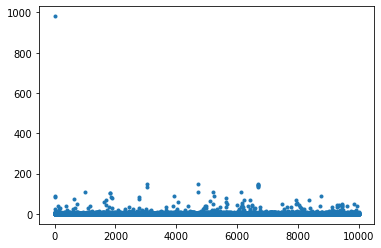

In [54]:
import matplotlib.pyplot as plt
re = (model.I != model_ours.I)
re.sum(1)
plt.plot(re.sum(1),".")

### Calculate risk

In [24]:
def get_risk_MultiSimRank(model):
    risk = pd.Series(model.I.sum(1))

    risk = (risk / risk.max()).sort_values()

    risk.sort_values(ascending=False, inplace=True)
    return risk

In [25]:
risk_ours = get_risk_MultiSimRank(model_ours)

In [26]:
risk_ours.head(20)

8182    1.000
9438    1.000
1085    0.985
5647    0.980
8345    0.967
1839    0.964
4698    0.951
6118    0.947
3032    0.924
6688    0.924
3033    0.093
6692    0.092
4699    0.086
6689    0.080
6693    0.079
6690    0.073
1837    0.065
1838    0.057
3915    0.053
1904    0.047
dtype: float64

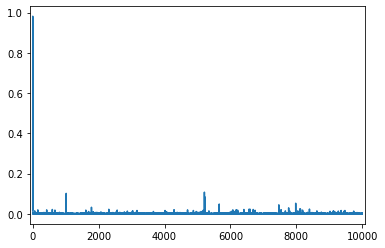

In [33]:
(risk_ours - risk).abs().plot(xlim=(-80,10080))

In [ ]:
risk.plot()

In [25]:
risk_ours[1], risk[1]

(0.001, 0.983)